In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import normalize, MinMaxScaler
import requests
from IPython.display import HTML
import matplotlib.pyplot as plt
import operator

In [2]:
card_images_dict = eval(requests.get('https://us-central1-royaleapp.cloudfunctions.net/getcardimages').text)

# Read in GC Data

In [3]:
df = pd.read_csv('../../../gc-data-2020.04-100000.csv')

for i in range(1,9):
    df['card'+str(i)] = df['card'+str(i)].apply(lambda x: x.replace('-', ' ').title().replace('Pekka', 'P.E.K.K.A').replace('X Bow', 'X-Bow'))
    
print(df.shape)
df.head()

(100001, 9)


,doc_id,card1,card2,card3,card4,card5,card6,card7,card8
0,2VVQ2RGC8-1585715128000-CYJGP8CL-R,Baby Dragon,Barbarian Barrel,Freeze,Goblins,Graveyard,Ice Wizard,Mega Knight,Tornado
1,RL2QYVY8-1586229529000-92CL822V,Balloon,Barbarian Barrel,Bats,Giant Snowball,Goblins,Ice Spirit,Lumberjack,Princess
2,8RUUL28QR-1585861468000-L2CUU2Y29-R,Baby Dragon,Barbarian Barrel,Firecracker,Golem,Lightning,Lumberjack,Night Witch,Tornado
3,GYRYCPV8-1586233796000-998GRLRY-R,Baby Dragon,Barbarian Barrel,Bomb Tower,Graveyard,Knight,Musketeer,Poison,Skeletons
4,8P8CV9LQC-1586291071000-9LR0C8VU-R,Balloon,Giant Snowball,Ice Golem,Inferno Tower,Miner,Musketeer,Skeletons,Valkyrie


In [4]:
# Out of 100,000 decks, only 903 are used at least 10 times
# How are these decks selected?
decks_str = df[['card'+str(i) for i in range(1,9)]].apply(lambda x: str(sorted(x)), axis=1).values.tolist()

len([(d,c) for d,c in Counter(decks_str).most_common() if c>=10])

903

In [60]:
# Only take unique decks - 15,380 of them
decks = df[['card'+str(i) for i in range(1,9)]].values.tolist()

# Save deck counts dictionary before taking the set of all decks
decks = [str(sorted(d)) for d in decks if 'Heal' not in d]
deck_counts = Counter(decks)

decks = set(decks)
decks = [eval(d) for d in decks]
len(decks)

15380

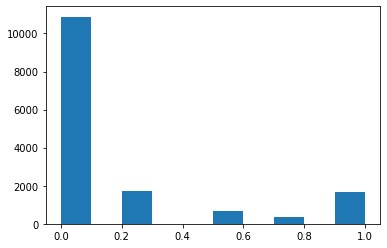

In [124]:
# Clip deck counts between 0 and 5, and normalize between 0 and 1
upper_deck_limit = 5

d_ = []
counts = []
for d,c in deck_counts.most_common():
    d_.append(d)
    counts.append(c)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_counts = scaler.fit_transform(np.clip(np.array(counts), 0, upper_deck_limit).reshape(-1, 1)).flatten()

# Inspect distribution of normalized count weights
plt.hist(scaled_counts)
plt.show();

# Finalize deck counts dictionary
normed_deck_counts = dict(zip(d_, scaled_counts))

# Read in Excel Stats

In [9]:
card_stats = pd.read_excel('../../../card_stats.xlsx')
stats_dict = dict(zip(card_stats['name'], card_stats.values[:,1:]))
card2ind = dict(zip(card_stats['name'], card_stats.index))

# Create Deck Matrices

In [10]:
percentile_max = 105
percentile_step = 5

In [11]:
# Card stats matrix
deck_matrix = np.array([normalize(np.percentile(np.array([stats_dict[c] for c in deck]), list(np.arange(0,percentile_max,percentile_step)), axis=0).flatten().reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0] for deck in tqdm(decks)])

100%|███████████████████████████████████████████████████████████████████████████| 15380/15380 [00:15<00:00, 969.84it/s]


In [12]:
# One-hot cards matrix
one_hot_deck_matrix = []
for deck in tqdm(decks):
    blank_vec = np.zeros(len(card_stats['name']))
    for card in deck:
        blank_vec[card2ind[card]] = 1
    blank_vec = normalize(blank_vec.reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0]
    one_hot_deck_matrix.append(blank_vec)
    
one_hot_deck_matrix = np.array(one_hot_deck_matrix)

100%|██████████████████████████████████████████████████████████████████████████| 15380/15380 [00:03<00:00, 4304.30it/s]


In [13]:
# One-hot win condition matrix

wincons = ['Giant', 'P.E.K.K.A', 'Balloon', 'Golem', 'Prince', 'Giant Skeleton', 'Hog Rider',
           'Royal Giant', 'Three Musketeers', 'Lava Hound', 'Miner', 'Sparky', 'Battle Ram', 
           'Elite Barbarians', 'Royal Recruits', 'Ram Rider', 'Mega Knight', 'Skeleton Barrel',
           'Wall Breakers', 'Royal Hogs', 'Goblin Giant', 'Elixir Golem', 'Mortar', 'X-Bow',
           'Rocket', 'Goblin Barrel', 'Graveyard']
wincon2ind = {w:i for w,i in card2ind.items() if w in wincons}

one_hot_wincon_deck_matrix = []
for deck in tqdm(decks):
    blank_vec = np.zeros(len(card_stats['name']))
    for card in deck:
        wincon_index = wincon2ind.get(card)
        if wincon_index:
            blank_vec[wincon_index] = 1
    blank_vec = normalize(blank_vec.reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0]
    one_hot_wincon_deck_matrix.append(blank_vec)
    
one_hot_wincon_deck_matrix = np.array(one_hot_wincon_deck_matrix)

100%|██████████████████████████████████████████████████████████████████████████| 15380/15380 [00:03<00:00, 4519.17it/s]


# Get Recommendations

In [119]:
def display_decks(decks, input_deck, sims, play_count_dict=deck_counts):
    deck_image_str = '<table>'
    for n, deck in enumerate(decks):
        deck_image_str += '<tr>'
        card_count = 0
        for card in deck:
            if card in input_deck:
                card_count += 1
            deck_image_str += '<td><img src={} style="height:75px"></td>'.format(card_images_dict[card])
        deck_image_str += '<td>{}/8 same cards</td>'.format(card_count)
        deck_image_str += '<td>score: {:.5f}</td>'.format(sims[n])
        deck_image_str += '<td>play count: {}</td>'.format(deck_counts[str(deck)])
        deck_image_str += '</tr>'
    deck_image_str += '</table>'
    display(HTML(deck_image_str))
    
def get_decks_sims(input_inds, input_sims, input_deck, all_decks=decks):
    rec_decks = []
    rec_sims = []
    for n, r in enumerate(input_inds):
        if all_decks[r] != input_deck:
            rec_decks.append(all_decks[r])
            rec_sims.append(input_sims[n])

    return rec_decks, rec_sims

def get_decks_sims2(input_decks, input_sims, input_deck, all_decks=decks):
    rec_decks = []
    rec_sims = []
    for n, d in enumerate(input_decks):
        if d != input_deck:
            rec_decks.append(d)
            rec_sims.append(input_sims[n])

    return rec_decks, rec_sims

In [145]:
# input_deck = ['Arrows', 'Balloon', 'Guards', 'Lava Hound', 'Mega Minion', 'Miner', 'Minions', 'Zap']
# input_deck = ['Archers', 'Fireball', 'Ice Golem', 'Ice Spirit', 'The Log', 'Skeletons', 'Tesla', 'X-Bow']
# input_deck = ['Giant Snowball', 'Bandit', 'Ram Rider', 'Electro Wizard', 'Barbarian Barrel', 'Poison', 'Baby Dragon', 'P.E.K.K.A']
# input_deck = ['Bats', 'Arrows', 'Miner', 'Wall Breakers', 'Musketeer', 'Electro Wizard', 'Mega Knight', 'Bandit']
input_deck = ['Ice Golem', 'Ice Spirit', 'Fireball', 'Cannon', 'Hog Rider', 'The Log', 'Skeletons', 'Musketeer']
# input_deck = []
random_ind = 1498 #np.random.choice(range(len(decks))) #11142 #10353 #12059 #6024 #1 #10545 #1498

n_recs = 6
input_deck = sorted(input_deck)

* Stats Recommendations: Purely based on aggregated deck stats from individual card stats (used on my website). Seeks to find decks with the most similar "feel" or play style.
* One-Hot Recommendations: Purely based on exact card contents (like those on RoyaleAPI). Seeks to find decks with the most number of similar cards.
* 50/50 Blended Recommendations: A blend of 50% Stats Recommendations and 50% One-Hot Recommendations. Seeks to find decks with similar "feel" or play style, as well as all similar cards.
* 50/50 Blended WinCon Recommendations: A blend of 50% Stats Recommendations and 50% One-Hot Win Condition Recommendations. One-Hot Win Condition Recommendations only give weight to win conditions in a deck. Seeks to find decks with similar "feel" or play style, as well as similar win conditions.
* 50/50 Blended WinCon Recommendations + Play Counts: Top-n recommendations are found with the 50/50 Blended WinCon Recommendations algorithm, and then those results are re-ranked to give more weight to decks which are played more frequently. Seeks to display the most played 50/50 Blended WinCon Recommendations decks. This sort of recommendation would additionally benefit from a win count or percentage per deck.

Overall, we get superior, diverse recommendations using 50/50 Blended WinCon Recommendations (with or without Play Counts). These recommendations show the user novel decks to play given their play style. Only when the user is truly looking for very, very similar decks does One-Hot Recommendations look appropriate. Even then, if the deck is a bit odd (golem_support.png) then it may fail to give more weight to the central card in the deck (golem). Further, switching out one or two cards in a deck is not difficult, and users may not need this as they can do it themselves.

In [146]:
if not input_deck:
    input_deck = decks[random_ind]

stat_embedding = normalize(np.percentile(np.array([stats_dict[c] for c in input_deck]), list(np.arange(0,percentile_max,percentile_step)), axis=0).flatten().reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0]

onehot_embedding = np.zeros(len(card_stats['name']))
for card in input_deck:
    onehot_embedding[card2ind[card]] = 1
onehot_embedding = normalize(onehot_embedding.reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0]

onehot_wincon_embedding = np.zeros(len(card_stats['name']))
for card in input_deck:
    wincon_index = wincon2ind.get(card)
    if wincon_index:
        onehot_wincon_embedding[wincon_index] = 1
onehot_wincon_embedding = normalize(onehot_wincon_embedding.reshape(-1, 1), norm='l2', axis=0).reshape(1,-1)[0]

rec_sims = stat_embedding.dot(deck_matrix.T)
onehot_rec_sims = onehot_embedding.dot(one_hot_deck_matrix.T)
blended_sims = rec_sims*.5 + onehot_rec_sims*.5
blended_wincon_rec_sims = onehot_wincon_embedding.dot(one_hot_wincon_deck_matrix.T)*.5 + rec_sims*.5

rec_inds = np.argsort(rec_sims)[::-1][:n_recs]
onehot_rec_inds = np.argsort(onehot_rec_sims)[::-1][:n_recs]
blended_rec_inds = np.argsort(blended_sims)[::-1][:n_recs]
blended_wincon_rec_inds = np.argsort(blended_wincon_rec_sims)[::-1]
blended_wincon_playcount_rec_decks = [(decks[ind], blended_wincon_rec_sims[ind]*0.5+normed_deck_counts[str(decks[ind])]*0.5) \
                                      for ind in blended_wincon_rec_inds[:50]]

print('Input Deck:')
display_decks([input_deck], input_deck, [1])

print('\nStats Recommendations:')
rec_decks, rec_sims = get_decks_sims(rec_inds, rec_sims[rec_inds], input_deck)
display_decks(rec_decks, input_deck, rec_sims)
    
print('\nOne-Hot Recommendations:')
rec_decks, rec_sims = get_decks_sims(onehot_rec_inds, onehot_rec_sims[onehot_rec_inds], input_deck)
display_decks(rec_decks, input_deck, rec_sims)

print('\n50/50 Blended Recommendations:')
rec_decks, rec_sims = get_decks_sims(blended_rec_inds, blended_sims[blended_rec_inds], input_deck)
display_decks(rec_decks, input_deck, rec_sims)

print('\n50/50 Blended WinCon Recommendations:')
rec_decks, rec_sims = get_decks_sims(blended_wincon_rec_inds[:n_recs], blended_wincon_rec_sims[blended_wincon_rec_inds[:n_recs]], input_deck)
display_decks(rec_decks, input_deck, rec_sims)

print('\n50/50 Blended WinCon Recommendations + Play Counts:')
rec_decks = [] 
rec_sims = []
for deck, sim in sorted(blended_wincon_playcount_rec_decks, key=operator.itemgetter(1), reverse=True):
    rec_decks.append(deck)
    rec_sims.append(sim)
rec_decks, rec_sims = get_decks_sims2(rec_decks[:n_recs], rec_sims[:n_recs], input_deck)
display_decks(rec_decks, input_deck, rec_sims)

Input Deck:


,,,,,,,,8/8 same cards,score: 1.00000,play count: 1395



Stats Recommendations:


,,,,,,,,7/8 same cards,score: 0.99917,play count: 6
,,,,,,,,7/8 same cards,score: 0.99876,play count: 1
,,,,,,,,7/8 same cards,score: 0.99871,play count: 1
,,,,,,,,7/8 same cards,score: 0.99802,play count: 14
,,,,,,,,7/8 same cards,score: 0.99778,play count: 5



One-Hot Recommendations:


,,,,,,,,7/8 same cards,score: 0.87500,play count: 1
,,,,,,,,7/8 same cards,score: 0.87500,play count: 1
,,,,,,,,7/8 same cards,score: 0.87500,play count: 1
,,,,,,,,7/8 same cards,score: 0.87500,play count: 1
,,,,,,,,7/8 same cards,score: 0.87500,play count: 1



50/50 Blended Recommendations:


,,,,,,,,7/8 same cards,score: 0.93708,play count: 6
,,,,,,,,7/8 same cards,score: 0.93688,play count: 1
,,,,,,,,7/8 same cards,score: 0.93685,play count: 1
,,,,,,,,7/8 same cards,score: 0.93651,play count: 14
,,,,,,,,7/8 same cards,score: 0.93639,play count: 5



50/50 Blended WinCon Recommendations:


,,,,,,,,7/8 same cards,score: 0.99958,play count: 6
,,,,,,,,7/8 same cards,score: 0.99935,play count: 1
,,,,,,,,7/8 same cards,score: 0.99901,play count: 14
,,,,,,,,7/8 same cards,score: 0.99889,play count: 5
,,,,,,,,7/8 same cards,score: 0.99889,play count: 1



50/50 Blended WinCon Recommendations + Play Counts:


,,,,,,,,7/8 same cards,score: 0.99979,play count: 6
,,,,,,,,7/8 same cards,score: 0.99950,play count: 14
,,,,,,,,7/8 same cards,score: 0.99945,play count: 5
,,,,,,,,7/8 same cards,score: 0.99933,play count: 107
,,,,,,,,7/8 same cards,score: 0.99908,play count: 17
